EE-608 Wireless Communications - Homework 04<br>
<font color="salmon">Rishabh Pomaje<br>
210020036@iitdh.ac.in

**OFDM** <br>
Implementing **O**rthogonal **F**requency **D**ivision **M**ultiplexing

1. **M**odulation and **C**oding **S**cheme (**MCS**) index 3 in WiFi 6 (https://en.wikipedia.org/wiki/Wi-Fi_6)
2. 16-QAM modulation  
3. (8,4) Hamming code $\implies R = 1/2$

- A 20 MHz channel with a 1600 ns guard interval
- An 80 MHz channel with an 800 ns guard interval.

4. Average energy input to the channel power OFDM symbol = 1 unit
5. Assume transmission over a fading channel with 128 taps, each spaced 12.5 ns apart, starting from 0 ns 
6. $h \overset{iid}{\sim} \mathcal{CN}(0, 1) $ :: Channel Gain Model 
7. $w \overset{iid}{\sim} \mathcal{CN}(0, N_0)$ :: Additive-White-Gaussian-Noise

In [11]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import tabulate
%config InlineBackend.figure_format='svg'

> Functions Definitions

In [12]:
# Function Definitions :
def hamming_encoder(input_stream, gnrtr_matrix) :
    """
    Function that first generates a codebook depending on the generator matrix 
    (provide as a numpy multi-dimensional ndarray). 
    Using that codebook, it performs the channel coding using Hamming codes.
    Returns a channel coded bit stream generated as per the Generator Matrix specified.
    """  
    input_size = len(input_stream)
    # k = length of the input packet ; n = length of the output packet
    k, n = np.shape(gnrtr_matrix)
    # Generating the codebook :
    code_book = np.array([], dtype=int)
    possible_inputs = [list(i) for i in itertools.product([0, 1], repeat=k)]
    for i in range(2 ** k) :
        code_word = np.array(np.matmul(possible_inputs[i], gnrtr_matrix) % 2)
        code_book = np.append(code_book, code_word) 
    code_book = code_book.reshape(2 ** k, n)
    # Encoding the stream using the codebook :
    index = 0
    channel_coded_stream = []
    for i in range(input_size // k) :
        temp = input_stream[index:index+k]
        asgn_id = np.sum(temp * 2 ** np.arange(k - 1, -1, -1))
        channel_coded_stream.append(code_book[int(asgn_id)])
        index = index + k
        
    channel_coded_stream = np.array(channel_coded_stream)

    return channel_coded_stream.flatten()

def QAM_16_mapper(input_stream) :
    """
    Function to perform 16-QAM Constellation Mapping with E_sym being the energy per symbol. 
    """
    if len(input_stream) % 4 != 0 :
        raise ValueError("Number of bits to be mapped must be a multiple of 4 for 16-QAM Mapping ; Try again after zero padding")
    E_sym = 10
    output_stream = []
    scale_factor = np.sqrt(E_sym / 10)  # Scale factor based on energy
    for i in range(0, len(input_stream), 4):
        bit_block = ''.join(map(str, input_stream[i:i+4]))
        if bit_block == '0000':
            output_stream.append(scale_factor * complex(-3, -3))
        elif bit_block == '0001':
            output_stream.append(scale_factor * complex(-3, -1))
        elif bit_block == '0011':
            output_stream.append(scale_factor * complex(-3, 1))
        elif bit_block == '0010':
            output_stream.append(scale_factor * complex(-3, 3))
        elif bit_block == '0110':
            output_stream.append(scale_factor * complex(-1, 3))
        elif bit_block == '0111':
            output_stream.append(scale_factor * complex(-1, 1))
        elif bit_block == '0101':
            output_stream.append(scale_factor * complex(-1, -1))
        elif bit_block == '0100':
            output_stream.append(scale_factor * complex(-1, -3))
        elif bit_block == '1100':
            output_stream.append(scale_factor * complex(1, -3))
        elif bit_block == '1101':
            output_stream.append(scale_factor * complex(1, -1))
        elif bit_block == '1111':
            output_stream.append(scale_factor * complex(1, 1))
        elif bit_block == '1110':
            output_stream.append(scale_factor * complex(1, 3))
        elif bit_block == '1010':
            output_stream.append(scale_factor * complex(3, 3))
        elif bit_block == '1011':
            output_stream.append(scale_factor * complex(3, 1))
        elif bit_block == '1001':
            output_stream.append(scale_factor * complex(3, -1))
        elif bit_block == '1000':
            output_stream.append(scale_factor * complex(3, -3))
        else:
            raise ValueError("Invalid bit block encountered during 16-QAM mapping")
    return np.array(output_stream)

def OFDM_gnrtr(csymbols_tx, num_subcarriers, num_prefixes, OFDM_energy) :
    OFDM_tx = []
    num_OFDMsyms = len(csymbols_tx) // num_subcarriers
    idx = 0 
    for _ in range(num_OFDMsyms) :
        # Taking the IFFT to convert to time domain :
        temp = np.fft.ifft(csymbols_tx[idx:idx+num_subcarriers], norm="ortho")
        # Appending the prefixes :
        temp = np.append(temp, temp[-1*(num_prefixes):])
        # Performing the cyclic shifts :
        temp = np.roll(temp, num_prefixes)
        # Normalising the energy of the OFDM Symbol : OFDM_energy = 1 
        temp = OFDM_energy * (temp / np.linalg.norm(temp))
        # Appending the generated the OFDM Symbol :
        OFDM_tx.append(temp)
        idx = idx + num_subcarriers
    # Final OFDM Symbol stream to be put on the channel
    OFDM_tx = np.array(OFDM_tx).flatten()
    # Appending dummy symbols : # of Dummy symbols = 32 = Number of Prefixes
    OFDM_tx = np.roll(np.append(OFDM_tx, np.full(num_prefixes, 1+1j)), num_prefixes)
    return OFDM_tx

def QAM_16_demapper(input_symbols, E_avg):
    """
    Function to perform 16-QAM Constellation Demapping with a given average symbol energy.
    """
    output_bits = []
    scale_factor = np.sqrt(E_avg / 10)  # Scale factor based on average symbol energy
    
    for symbol in input_symbols:
        symbol_real = symbol.real / scale_factor
        symbol_imag = symbol.imag / scale_factor
        
        if symbol_real < -2:
            if symbol_imag < -2:
                output_bits.extend([0, 0, 0, 0])
            elif symbol_imag < 0:
                output_bits.extend([0, 0, 0, 1])
            elif symbol_imag < 2:
                output_bits.extend([0, 0, 1, 1])
            else:
                output_bits.extend([0, 0, 1, 0])
        elif symbol_real < 0:
            if symbol_imag < -2:
                output_bits.extend([0, 1, 0, 0])
            elif symbol_imag < 0:
                output_bits.extend([0, 1, 0, 1])
            elif symbol_imag < 2:
                output_bits.extend([0, 1, 1, 1])
            else:
                output_bits.extend([0, 1, 1, 0])
        elif symbol_real < 2:
            if symbol_imag < -2:
                output_bits.extend([1, 1, 0, 0])
            elif symbol_imag < 0:
                output_bits.extend([1, 1, 0, 1])
            elif symbol_imag < 2:
                output_bits.extend([1, 1, 1, 1])
            else:
                output_bits.extend([1, 1, 1, 0])
        else:
            if symbol_imag < -2:
                output_bits.extend([1, 0, 0, 0])
            elif symbol_imag < 0:
                output_bits.extend([1, 0, 0, 1])
            elif symbol_imag < 2:
                output_bits.extend([1, 0, 1, 1])
            else:
                output_bits.extend([1, 0, 1, 0])
    
    return np.array(output_bits)


def hamming_decoder(rx_stream, parity_chk_matrix):
    """
    Function to perform hard decision syndrome decoding for Hamming codes, given a bit stream and parity check matrix 
    as input.
    Returns 't-error' corrected stream. The current implementation is matrix based and hence inefficient.
    NOTE: The matrices provided as inputs to this function must be ndarray with dtype = int.
    """
    # Get the size of the input stream and dimensions of the parity check matrix
    input_size = len(rx_stream) 
    k_1, n = np.shape(parity_chk_matrix)
    k = n - k_1
    decoded_stream = np.zeros((input_size // n, k), dtype=int)
    # Generating the syndrome book :
    possible_single_errors = np.eye(n, dtype=int) 
    syndrome_book = parity_chk_matrix.T
    # Performing the syndrome decoding :
    num_blocks = input_size // n 
    for idx in range(num_blocks):
        rx_packet = rx_stream[idx * n: (idx + 1) * n]  # Extract packet for processing
        syndrome = np.matmul(rx_packet, parity_chk_matrix.T) % 2
        if np.sum(syndrome) != 0 :
        # Correcting 1-bit errors :
            for j in range(n):
                if np.array_equal(syndrome, syndrome_book[j]):
                    rx_packet = np.bitwise_xor(rx_packet, possible_single_errors[j])
        decoded_stream[idx] = rx_packet[:k]  # Append the corrected packet
        
    return decoded_stream.flatten()

def OFDM_decoder(OFDM_rx, num_prefixes, num_subcarriers, FADE, parity_chk_mat) :
    # Removing the excess (Dummy Symbol + Residual at the end) 
    OFDM_clear = OFDM_rx[num_prefixes:-1*(num_prefixes)]
    # Dropping the prefixes :
    OFDM_sliced = []
    idx = 0 
    while idx < len(OFDM_clear) :
        if (idx % (num_prefixes + num_subcarriers) == 0) :
            idx = idx + num_prefixes
        else :
            OFDM_sliced.append(OFDM_clear[idx])
            idx = idx + 1 
    OFDM_sliced = np.array(OFDM_sliced).reshape(-1,num_subcarriers)
    
    # Taking the FFT block-by-block:
    for pkt_id in range(len(OFDM_sliced)) :
        OFDM_sliced[pkt_id] = np.fft.fft(OFDM_sliced[pkt_id], norm="ortho")
    
    # Performing decoding of the received OFDM symbols
    csymbols_rx = [] 
    for i in range(len(OFDM_sliced)):
        Y = OFDM_sliced[i]
        # Rectifying using H*Y/|H|^2
        Y = np.conjugate(FADE) * Y / np.abs(FADE) 
        # Adjusting the constellation symbol energy since we had normalised the ODFM block energy
        adjust_factor = np.sqrt(10 * (num_prefixes + num_subcarriers))
        Y = Y * adjust_factor
        csymbols_rx.append(Y) # First appending the rectified complex symbols
    
    # 16-QAM Demodulation using MLD --> Minimum Distance Rule :
    ccoded_rx = QAM_16_demapper(np.array(csymbols_rx).flatten(), np.mean(np.linalg.norm(np.array(csymbols_rx).flatten())))
    
    # Performing Hamming (8, 4) syndrome decoding :
    binary_rx = hamming_decoder(ccoded_rx, parity_chk_mat)
    return binary_rx

# Miscellaneous Functions for Pre/ Post Processing of the data
def str2bin(input_string) :
    """
    Function to conert a string to ASCII binary stream
    """
    # Use list comprehension to convert each character to its ASCII value and then to binary
    binary_array = [format(ord(char), '08b') for char in input_string]
    # Flatten the list of binary strings into a single list of integers
    binary_array = [int(bit) for binary_str in binary_array for bit in binary_str]
    return np.array(binary_array, dtype=int)

def bin2str(binary_array) :
        # Conversion to byte array :
        byte_array = np.packbits(binary_array)
        # Decode byte array to ASCII string :
        return byte_array.tobytes().decode('ascii')

def calcBLER(original_message, estimated_message, block_length) :
    """ 
    Function to calculate the block error rate 
    """
    n_errors = 0
    n_blocks = len(original_message) // block_length
    idx = 0
    for _ in range(n_blocks) :
        if not np.all(original_message[idx:idx+block_length] == estimated_message[idx:idx+block_length]) :
            n_errors += 1 
        idx += block_length  
    return [n_errors, n_errors / n_blocks]    

> Parameter Definitions 

In [13]:
# System Specifications :
# Given information :
mcs_idx = 3                                                         # Only for reference (as per WiFi 6)
k = 4                                                               # input block length
n = 8                                                               # output block length
R = k / n                                                           # Information rate
BW = np.array([20 * (10 ** 6), 80 * (10 ** 6)])                     # Bandwidths [BW1, BW2] in Hz
GI = np.array([1600 * (10 ** -9), 800 * (10 ** -9)])                # Guard intervals [GI1, GI2] in seconds
OFDM_energy = 1
tap_interval = 12.5 * (10 ** -9)
# Inferred information :
T_s = 1 / BW                                                        # Symbol duration without OFDM
# T = num_taps * tap_interval                                       # Symbol Duration with OFDM T = N*T_s
T= 12.8 * (10 ** -6)                                                # Symbol Duration with OFDM T = N*T_s
num_subcarriers = np.array(T / T_s, dtype=int)                      # _ per OFDM block
num_prefixes = np.array(GI / T_s, dtype=int)                        # _ per OFDM block
num_taps = num_prefixes + 1
# Displaying :
table = (
    ["Entity\Bandwidth", f'{BW[0] / (10 ** 6)} MHz', f'{BW[1] / (10 ** 6)} MHz'], 
    ["OFDM symbol energy", OFDM_energy, OFDM_energy],
    ["# of fade taps", num_taps[0], num_taps[1]],
    ["Coherence Period", tap_interval, tap_interval],
    ["GI", GI[0], GI[1]],
    ["T_s", T_s[0], T_s[1]],
    ["T", T, T],
    ["# of Sub-Carriers (N)", num_subcarriers[0], num_subcarriers[1]],
    ["# of Cyclic Prefixes", num_prefixes[0], num_prefixes[1]]
    )
print(tabulate.tabulate(table, headers="firstrow", tablefmt="grid"))

+-----------------------+------------+-------------+
| Entity\Bandwidth      |   20.0 MHz |    80.0 MHz |
+=======================+============+=============+
| OFDM symbol energy    |   1        |    1        |
+-----------------------+------------+-------------+
| # of fade taps        |  33        |   65        |
+-----------------------+------------+-------------+
| Coherence Period      |   1.25e-08 |    1.25e-08 |
+-----------------------+------------+-------------+
| GI                    |   1.6e-06  |    8e-07    |
+-----------------------+------------+-------------+
| T_s                   |   5e-08    |    1.25e-08 |
+-----------------------+------------+-------------+
| T                     |   1.28e-05 |    1.28e-05 |
+-----------------------+------------+-------------+
| # of Sub-Carriers (N) | 256        | 1024        |
+-----------------------+------------+-------------+
| # of Cyclic Prefixes  |  32        |   64        |
+-----------------------+------------+--------

In [14]:
# The generator and the parity check matrices for (8, 4) Hamming Code :
# In systematic form :
G = np.array([
    [1, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 1],
    [0, 0, 1, 0, 1, 1, 0, 1],
    [0, 0, 0, 1, 1, 1, 1, 0]
    ], dtype=int)

H = np.array([
    [0, 1, 1, 1, 1, 0, 0, 0],
    [1, 0, 1, 1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 0, 1, 0],
    [1, 1, 1, 0, 0, 0, 0, 1]
    ], dtype=int)

> Generation of Random Input Data

In [15]:
num_bits = (2 ** 10) * (10 ** 3)
num_bits = 1 * 512 ** 2 
print(num_bits)
binary_tx = np.random.randint(0, 2, num_bits)
print(f'test_input = {binary_tx}')

262144
test_input = [1 0 1 ... 0 1 1]


> Transmitter Block Processing :

Part I : Zero Padding + Channel Coding + Constellation Mapping

In [16]:
# Channel Coding : ccoded_tx = channel coded stream of bits at the transmitter
ccoded_tx = hamming_encoder(binary_tx, G)

# Constellation Mapping : csymbols_tx = constellation symbol stream at the transmitter
csymbols_tx = QAM_16_mapper(ccoded_tx)

# Creating the OFDM_block_stream for both the cases :
OFDM_tx_c1 = OFDM_gnrtr(csymbols_tx, num_subcarriers[0], num_prefixes[0], 1)
OFDM_tx_c2 = OFDM_gnrtr(csymbols_tx, num_subcarriers[1], num_prefixes[1], 1)

 > Channel

- Case 1 : 20 Mhz + 1600ns GI

In [17]:
# Generating the Rayleigh Fading Taps
fade_taps_c1 = np.random.normal(0, np.sqrt(0.5), num_taps[0]) + 1j*np.random.normal(0, np.sqrt(0.5), num_taps[0])
# FFT for Future use :
FADE_c1 = np.sqrt(num_subcarriers[0]) * np.fft.fft(fade_taps_c1, n=num_subcarriers[0], norm="ortho")
# Performing convolution to simulate the effect of the channel in discrete time :
OFDM_rx_c1 = np.convolve(fade_taps_c1, OFDM_tx_c1) 

- Case 2 : 80 Mhz + 800ns GI

In [18]:
# Generating the Rayleigh Fading Taps
fade_taps_c2 = np.random.normal(0, np.sqrt(0.5), num_taps[1]) + 1j*np.random.normal(0, np.sqrt(0.5), num_taps[1])
# FFT for Future use :
FADE_c2 = np.sqrt(num_subcarriers[1]) * np.fft.fft(fade_taps_c2, n=num_subcarriers[1], norm="ortho")
# Performing convolution to simulate the effect of the channel in discrete time :
OFDM_rx_c2 = np.convolve(fade_taps_c2, OFDM_tx_c2) 

> Receiver Processing :

In [19]:
n_values = 10
SNR_dB = np.linspace(10, 50, n_values)
SNR_lin = 10 ** (SNR_dB / 10)
noise_var = 1 / (2 * SNR_lin)
print(noise_var)

[5.00000000e-02 1.79690683e-02 6.45774833e-03 2.32079442e-03
 8.34050269e-04 2.99742125e-04 1.07721735e-04 3.87131841e-05
 1.39127970e-05 5.00000000e-06]


- Case 1 : 20 Mhz + 1600ns GI

In [20]:
BLER_case_1 = []
count = 0 
for noise in noise_var :
    # Adding AWGN noise :
    awgn = np.random.normal(0, np.sqrt(noise), np.shape(OFDM_rx_c1)) + 1j*np.random.normal(0, np.sqrt(noise), np.shape(OFDM_rx_c1))
    OFDM_rx_c1 = OFDM_rx_c1 + awgn
    binary_rx = OFDM_decoder(OFDM_rx_c1, num_prefixes[0], num_subcarriers[0], FADE_c1, H)
    _, BLER = calcBLER(binary_rx, binary_tx, 1)
    BLER_case_1.append(BLER)
    count = count + 1 
    print(f'Progress : {100 * count // n_values} %', end='\r')

- Case 2 : 80 Mhz + 800ns GI

In [21]:
BLER_case_2 = []
count = 0
for noise in noise_var :
    # Adding AWGN noise :
    awgn = np.random.normal(0, np.sqrt(noise), np.shape(OFDM_rx_c2)) + 1j*np.random.normal(0, np.sqrt(noise), np.shape(OFDM_rx_c2))
    OFDM_rx_c2 = OFDM_rx_c2 + awgn
    binary_rx = OFDM_decoder(OFDM_rx_c2, num_prefixes[1], num_subcarriers[1], FADE_c2, H)
    _, BLER = calcBLER(binary_rx, binary_tx, 1)
    BLER_case_2.append(BLER)
    count = count + 1
    print(f'Progress : {100 * count // n_values} %', end='\r')

> Visualization of the results :

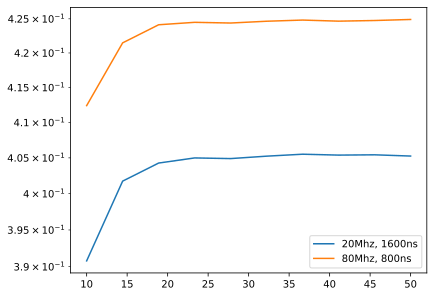

In [22]:
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_case_1, label='20Mhz, 1600ns')
axes.semilogy(SNR_dB, BLER_case_2, label='80Mhz, 800ns')
axes.legend()